In [1]:
!pip install pygame-ce pymunk stable-baselines3 shimmy>=2.0

In [2]:
!ls /content/

'=2.0'	 capture   drive   game_history   logs	 models   sample_data


In [3]:
!rm -r /content/capture
!rm -r /content/game_history
!rm -r /content/logs

# Classes

## Recorder

In [4]:
import json
import os
import datetime

class Recorder:

    def __init__(self, task: str = "game_history_record"):
        """
        tasks:
        1. game_history_record
        2. temp_memory
        """
        # CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
        CURRENT_DIR = ""
        if task == "game_history_record":
            collection_name = self.get_newest_record_name()
            self.json_file_path = CURRENT_DIR + "./game_history/" + collection_name + ".json"

        # Ensure directory exists
        os.makedirs(os.path.dirname(self.json_file_path), exist_ok=True)

        if os.path.exists(self.json_file_path):
            print("Loading the json memory file")
            self.memory = self.load(self.json_file_path)
        else:
            print("The json memory file does not exist. Creating new file.")
            self.memory = {"game_records": []}  # Direct dictionary instead of json.loads
            with open(self.json_file_path, "w") as f:
                json.dump(self.memory, f)

    def get(self):
        print("Getting the json memory")
        return self.memory

    def add_no_limit(self, data: float, ):
        """
        Add a records.

        Args:
            role: The role of the sender (e.g., 'user', 'assistant')
            message: The message content
        """
        self.memory["game_records"].append({
            "game_total_duration": data,
            "timestamp": str(datetime.datetime.now())
        })

        self.save(self.json_file_path)

    def save(self, file_path):
        try:
            with open(file_path, 'w') as f:
                json.dump(self.memory, f)
        except Exception as e:
            print(f"Error saving memory to {file_path}: {e}")

    def load(self, file_path):
        try:
            with open(file_path, 'r') as f:
                return json.load(f)
        except Exception as e:
            print(f"Error loading memory from {file_path}: {e}")
            return {"game_records": []}

    def get_newest_record_name(self) -> str:
        """
        傳回最新的對話歷史資料和集的名稱 (game_YYYY_MM)
            - 例如: "game_2022-01"
        """

        this_month = datetime.datetime.now().strftime("%Y-%m")
        return "record_" + this_month

## Shapes & Objects

In [5]:
import pymunk
from typing import Tuple, Optional

class Shape:

    def __init__(
                self,
                position: Tuple[float, float] = (300, 100),
                velocity: Tuple[float, float] = (0, 0),
                body: Optional[pymunk.Body] = None,
                shape: Optional[pymunk.Shape] = None,
            ):
        """
        Initialize a physical shape with associated body.

        Args:
            position: Initial position (x, y) of the body
            velocity: Initial velocity (vx, vy) of the body
            body: The pymunk Body to attach to this shape
            shape: The pymunk Shape for collision detection
        """

        self.body = body
        self.default_position = position
        self.default_velocity = velocity
        self.body.position = position
        self.body.velocity = velocity
        self.default_angular_velocity = 0

        self.shape = shape

    def reset(self):
        """Reset the body to its default position, velocity and angular velocity."""
        self.body.position = self.default_position
        self.body.velocity = self.default_velocity
        self.body.angular_velocity = self.default_angular_velocity


In [6]:
import pymunk

# from shapes.shape import Shape
from typing import Tuple, Optional

class Circle(Shape):

    def __init__(
                self,
                position: Tuple[float, float] = (300, 100),
                velocity: Tuple[float, float] = (0, 0),
                body: Optional[pymunk.Body] = None,
                shape_radio: float = 20,
                shape_mass: float = 1,
                shape_friction: float = 0.1,
            ):
        """
        Initialize a circular physics object.

        Args:
            position: Initial position (x, y) of the circle
            velocity: Initial velocity (vx, vy) of the circle
            body: The pymunk Body to attach this circle to
            shape_radio: Radius of the circle in pixels
            shape_mass: Mass of the circle
            shape_friction: Friction coefficient for the circle
        """

        super().__init__(position, velocity, body)
        self.shape_radio = shape_radio
        self.shape = pymunk.Circle(self.body, shape_radio)
        self.shape.mass = shape_mass
        self.shape.friction = shape_friction
        self.shape.elasticity = 0.8  # Add some bounce to make the simulation more interesting


## Game class

In [7]:
import pymunk
import pygame
import random
import time
import numpy as np
import os
from typing import Dict, Tuple, Optional

import numpy as np
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import IPython.display as ipd
# from shapes.circle import Circle
# from record import Recorder

class BalancingBallGame:
    """
    A physics-based balancing ball game that can run standalone or be used as a Gym environment.
    """

    # Game constants


    # Visual settings for indie style
    BACKGROUND_COLOR = (41, 50, 65)  # Dark blue background
    BALL_COLOR = (255, 213, 79)  # Bright yellow ball
    PLATFORM_COLOR = (235, 64, 52)  # Red platform
    PARTICLE_COLORS = [(252, 186, 3), (252, 127, 3), (252, 3, 3)]  # Fire-like particles



    def __init__(self,
                 render_mode: str = "human",
                 sound_enabled: bool = True,
                 difficulty: str = "medium",
                 window_x: int = 1000,
                 window_y: int = 600,
                 max_step: int = 30000,
                 reward_staying_alive: float = 0.1,
                 reward_ball_centered: float = 0.2,
                 penalty_falling: float = -10.0,
                 fps: int = 120,
                 platform_shape: str = "circle",
                 platform_length: int = 200,
                 capture_per_second: int = None,
                ):
        """
        Initialize the balancing ball game.

        Args:
            render_mode: "human" for visible window, "rgb_array" for gym env, "headless" for no rendering
            sound_enabled: Whether to enable sound effects
            difficulty: Game difficulty level ("easy", "medium", "hard")
            max_step: 1 step = 1/fps, if fps = 120, 1 step = 1/120
            reward_staying_alive: float = 0.1,
            reward_ball_centered: float = 0.2,
            penalty_falling: float = -10.0,
            fps: frame per second
            capture_per_second: save game screen as a image every second, None means no capture
        """
        # Game parameters
        self.max_step = max_step
        self.reward_staying_alive = reward_staying_alive
        self.reward_ball_centered = reward_ball_centered
        self.penalty_falling = penalty_falling
        self.fps = fps
        self.window_x = window_x
        self.window_y = window_y

        self.recorder = Recorder("game_history_record")
        self.render_mode = render_mode
        self.sound_enabled = sound_enabled
        self.difficulty = difficulty

        self._get_x_axis_max_reward_rate(platform_length)

        # Initialize physics space
        self.space = pymunk.Space()
        self.space.gravity = (0, 1000)
        self.space.damping = 0.9

        # Create game bodies
        self.dynamic_body = pymunk.Body()  # Ball body
        self.kinematic_body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)  # Platform body
        self.kinematic_body.position = (self.window_x / 2, 400)
        self.default_kinematic_position = self.kinematic_body.position

        # Create game objects
        self._create_ball()
        self._create_platform(platform_shape=platform_shape, platform_length=platform_length)
        # self._create_platform("rectangle")

        # Add all objects to space
        self.space.add(self.dynamic_body, self.kinematic_body,
                       self.circle.shape, self.platform)

        # Game state tracking
        self.steps = 0
        self.start_time = time.time()
        self.game_over = False
        self.score = 0
        self.particles = []

        # Initialize Pygame if needed
        if self.render_mode in ["human", "rgb_array", "rgb_array_and_human", "rgb_array_and_human_in_colab"]:
            self._setup_pygame()
        else:
            print("render_mode is not human or rgb_array, so no pygame setup.")

        # Set difficulty parameters
        self._apply_difficulty()
        self.capture_per_second = capture_per_second

        # Create folders for captures if needed
        # CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
        CURRENT_DIR = "."
        os.makedirs(os.path.dirname(CURRENT_DIR + "/capture/"), exist_ok=True)

    def _setup_pygame(self):
        """Set up PyGame for rendering"""
        pygame.init()
        self.frame_count = 0

        if self.sound_enabled:
            self._load_sounds()

        if self.render_mode == "human":
            self.screen = pygame.display.set_mode((self.window_x, self.window_y))
            pygame.display.set_caption("Balancing Ball - Indie Game")

        elif self.render_mode == "rgb_array":
            self.screen = pygame.Surface((self.window_x, self.window_y))

        elif self.render_mode == "rgb_array_and_human": # todo
            print("rgb_array_and_human mode is not supported yet.")

        elif self.render_mode == "rgb_array_and_human_in_colab": # todo
            from pymunk.pygame_util import DrawOptions

            self.screen = pygame.Surface((self.window_x, self.window_y))  # Create hidden surface

            # Set up display in Colab
            self.draw_options = DrawOptions(self.screen)
            html_display = ipd.HTML('''
                <div id="pygame-output" style="width:100%;">
                    <img id="pygame-img" style="width:100%;">
                </div>
            ''')
            self.display_handle = display(html_display, display_id='pygame_display')

            self.last_update_time = time.time()
            self.update_interval = 1.0 / 15  # Update display at 15 FPS to avoid overwhelming Colab


        else:
            print("Invalid render mode. Using headless mode.")

        self.clock = pygame.time.Clock()
        self.font = pygame.font.Font(None, 30)

        # Create custom draw options for indie style

    def _load_sounds(self):
        """Load game sound effects"""
        try:
            pygame.mixer.init()
            self.sound_bounce = pygame.mixer.Sound("assets/bounce.wav") if os.path.exists("assets/bounce.wav") else None
            self.sound_fall = pygame.mixer.Sound("assets/fall.wav") if os.path.exists("assets/fall.wav") else None
        except Exception:
            print("Sound loading error")
            self.sound_enabled = False
            pass

    def _create_ball(self):
        """Create the ball with physics properties"""
        self.ball_radius = 15
        self.circle = Circle(
            position=(self.window_x / 2, 200),
            velocity=(0, 0),
            body=self.dynamic_body,
            shape_radio=self.ball_radius,
            shape_friction=100,
        )
        # Store initial values for reset
        self.default_ball_position = self.dynamic_body.position

    def _create_platform(self,
                         platform_shape: str = "circle",
                         platform_length: int = 200
                        ):
        """
        Create the platform with physics properties
        platform_shape: circle, rectangle
        platform_length: Length of a rectangle or Diameter of a circle
        """
        if platform_shape == "circle":
            self.platform_length = platform_length / 2 # radius
            self.platform = pymunk.Circle(self.kinematic_body, self.platform_length)
            self.platform.mass = 1  # 质量对 Kinematic 物体无意义，但需要避免除以零错误
            self.platform.friction = 0.7
        elif platform_shape == "rectangle":
            self.platform_length = 200
            vs = [(-self.platform_length/2, -10),
                (self.platform_length/2, -10),
                (self.platform_length/2, 10),
                (-self.platform_length/2, 10)]

            self.platform = pymunk.Poly(self.kinematic_body, vs)
        self.platform.friction = 0.7
        self.platform_rotation = 0
        self.kinematic_body.angular_velocity = random.randrange(-1, 2, 2)

    def _apply_difficulty(self):
        """Apply difficulty settings to the game"""
        if self.difficulty == "easy":
            self.max_platform_speed = 1.5
            self.ball_elasticity = 0.5
        elif self.difficulty == "medium":
            self.max_platform_speed = 2.5
            self.ball_elasticity = 0.7
        else:  # hard
            self.max_platform_speed = 3.5
            self.ball_elasticity = 0.9

        self.circle.shape.elasticity = self.ball_elasticity

    def reset(self) -> np.ndarray:
        """Reset the game state and return the initial observation"""
        # Reset physics objects
        self.dynamic_body.position = self.default_ball_position
        self.dynamic_body.velocity = (0, 0)
        self.dynamic_body.angular_velocity = 0

        self.kinematic_body.position = self.default_kinematic_position
        self.kinematic_body.angular_velocity = random.randrange(-1, 2, 2)

        # Reset game state
        self.steps = 0
        self.start_time = time.time()
        self.game_over = False
        self.score = 0
        self.particles = []

        # Return initial observation
        return self._get_observation()

    def step(self, action: float) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Take a step in the game using the given action.

        Args:
            action: Float value between -1.0 and 1.0 controlling platform rotation

        Returns:
            observation: Game state observation
            reward: Reward for this step
            terminated: Whether episode is done
            info: Additional information
        """
        # Apply action to platform rotation
        self.dynamic_body.angular_velocity += action

        # Step the physics simulation
        self.space.step(1/self.fps)

        # Update particle effects
        self._update_particles()

        # Check game state
        self.steps += 1
        terminated = False
        reward = self.reward_staying_alive

        # Calculate reward for keeping ball centered on platform
        ball_x = self.dynamic_body.position[0]

        # Check if ball falls off screen
        if (self.dynamic_body.position[1] > self.kinematic_body.position[1] or
            self.dynamic_body.position[0] < 0 or
            self.dynamic_body.position[0] > self.window_x or
            self.steps >= self.max_step
            ):

            print("Score: ", self.score)
            terminated = True
            reward = self.penalty_falling if self.steps < self.max_step else 0
            self.game_over = True

            result = {
                "game_total_duration": f"{time.time() - self.start_time:.2f}",
                "score": self.score,
            }
            self.recorder.add_no_limit(result)

            if self.sound_enabled and self.sound_fall:
                self.sound_fall.play()

        step_reward = self._reward_calculator(ball_x)
        self.score += step_reward
        # print("ball_x: ", ball_x, ", self.score: ", self.score)
        return self._get_observation(), step_reward, terminated

    def _get_observation(self) -> np.ndarray:
        """Convert game state to observation for RL agent"""
        # # Normalize values to suitable ranges
        # ball_x = self.dynamic_body.position[0] / self.window_x
        # ball_y = self.dynamic_body.position[1] / self.window_y
        # ball_vx = self.dynamic_body.velocity[0] / 1000
        # ball_vy = self.dynamic_body.velocity[1] / 1000

        # platform_angle = (self.kinematic_body.angle % (2*np.pi)) / (2*np.pi)
        # platform_angular_velocity = self.kinematic_body.angular_velocity / self.max_platform_speed

        # return np.array([
        #     ball_x, ball_y, ball_vx, ball_vy,
        #     platform_angle, platform_angular_velocity
        # ], dtype=np.float32)

        # update particles and draw them
        self.render()

        if self.render_mode == "rgb_array_and_human_in_colab":
            # Update the image in Colab output at a reasonable interval
            current_time = time.time()
            if current_time - self.last_update_time >= self.update_interval:
                # Convert Pygame surface to an image that can be displayed in Colab
                buffer = BytesIO()
                pygame.image.save(self.screen, buffer, 'PNG') # todo screen 的畫面是全黑的，給模型進行預測的圖片也應該是全黑的，以及添加顯示模型正在執行什麽 action 的輸出
                buffer.seek(0)
                img_data = base64.b64encode(buffer.read()).decode('utf-8')

                # Update the HTML image
                self.display_handle.update(ipd.HTML(f'''
                    <div id="pygame-output" style="width:100%;">
                        <img id="pygame-img" src="data:image/png;base64,{img_data}" style="width:100%;">
                    </div>
                '''))

                self.last_update_time = current_time

        if self.capture_per_second is not None and self.frame_count % self.capture_per_second == 0:  # Every second at 60 FPS
            pygame.image.save(self.screen, f"capture/frame_{self.frame_count/60}.png")

        self.frame_count += 1
        screen_data = pygame.surfarray.array3d(self.screen)  # 获取数据
        screen_data = np.transpose(screen_data, (1, 0, 2))  # 转置以符合 (height, width, channels)

        return screen_data

    def _update_particles(self):
        """Update particle effects for indie visual style"""
        # Create new particles when ball hits platform
        if abs(self.dynamic_body.position[1] - (self.kinematic_body.position[1] - 20)) < 5 and abs(self.dynamic_body.velocity[1]) > 100:
            for _ in range(5):
                self.particles.append({
                    'x': self.dynamic_body.position[0],
                    'y': self.dynamic_body.position[1] + self.ball_radius,
                    'vx': random.uniform(-2, 2),
                    'vy': random.uniform(1, 3),
                    'life': 30,
                    'size': random.uniform(2, 5),
                    'color': random.choice(self.PARTICLE_COLORS)
                })

            if self.sound_enabled and self.sound_bounce:
                self.sound_bounce.play()

        # Update existing particles
        for particle in self.particles[:]:
            particle['x'] += particle['vx']
            particle['y'] += particle['vy']
            particle['life'] -= 1
            if particle['life'] <= 0:
                self.particles.remove(particle)

    def render(self) -> Optional[np.ndarray]:
        """Render the current game state"""
        if self.render_mode == "headless":
            return None

        # Clear screen with background color
        self.screen.fill(self.BACKGROUND_COLOR)

        # Custom drawing (for indie style)
        self._draw_indie_style()

        # Draw game information
        self._draw_game_info()

        # Update display if in human mode
        if self.render_mode == "human":
            pygame.display.flip()
            self.clock.tick(self.fps)
            return None

        elif self.render_mode == "rgb_array":
            # Return RGB array for gym environment
            return pygame.surfarray.array3d(self.screen)

        elif self.render_mode == "rgb_array_and_human": # todo
            print("rgb_array_and_human mode is not supported yet.")

        elif self.render_mode == "rgb_array_and_human_in_colab":
            self.space.debug_draw(self.draw_options)
            return pygame.surfarray.array3d(self.screen)
        else:
            pass

    def _draw_indie_style(self):
        """Draw game objects with indie game aesthetic"""
        # # Draw platform with gradient and glow
        # platform_points = []
        # for v in self.platform.get_vertices():
        #     x, y = v.rotated(self.kinematic_body.angle) + self.kinematic_body.position
        #     platform_points.append((int(x), int(y)))

        # pygame.draw.polygon(self.screen, self.PLATFORM_COLOR, platform_points)
        # pygame.draw.polygon(self.screen, (255, 255, 255), platform_points, 2)

        platform_pos = (int(self.kinematic_body.position[0]), int(self.kinematic_body.position[1]))
        pygame.draw.circle(self.screen, self.PLATFORM_COLOR, platform_pos, self.platform_length)
        pygame.draw.circle(self.screen, (255, 255, 255), platform_pos, self.platform_length, 2)

        # Draw rotation direction indicator
        self._draw_rotation_indicator(platform_pos, self.platform_length, self.kinematic_body.angular_velocity)

        # Draw ball with gradient and glow
        ball_pos = (int(self.dynamic_body.position[0]), int(self.dynamic_body.position[1]))
        pygame.draw.circle(self.screen, self.BALL_COLOR, ball_pos, self.ball_radius)
        pygame.draw.circle(self.screen, (255, 255, 255), ball_pos, self.ball_radius, 2)

        # Draw particles
        for particle in self.particles:
            alpha = min(255, int(255 * (particle['life'] / 30)))
            pygame.draw.circle(
                self.screen,
                particle['color'],
                (int(particle['x']), int(particle['y'])),
                int(particle['size'])
            )

    def _draw_rotation_indicator(self, position, radius, angular_velocity):
        """Draw an indicator showing the platform's rotation direction and speed"""
        # Only draw the indicator if there's some rotation
        if abs(angular_velocity) < 0.1:
            return

        # Calculate indicator properties based on angular velocity
        indicator_color = (50, 255, 150) if angular_velocity > 0 else (255, 150, 50)
        num_arrows = min(3, max(1, int(abs(angular_velocity))))
        indicator_radius = radius - 20  # Place indicator inside the platform

        # Draw arrow indicators along the platform's circumference
        start_angle = self.kinematic_body.angle

        for i in range(num_arrows):
            # Calculate arrow position
            arrow_angle = start_angle + i * (2 * np.pi / num_arrows)

            # Calculate arrow start and end points
            base_x = position[0] + int(np.cos(arrow_angle) * indicator_radius)
            base_y = position[1] + int(np.sin(arrow_angle) * indicator_radius)

            # Determine arrow direction based on angular velocity
            if angular_velocity > 0:  # Clockwise
                arrow_end_angle = arrow_angle + 0.3
            else:  # Counter-clockwise
                arrow_end_angle = arrow_angle - 0.3

            tip_x = position[0] + int(np.cos(arrow_end_angle) * (indicator_radius + 15))
            tip_y = position[1] + int(np.sin(arrow_end_angle) * (indicator_radius + 15))

            # Draw arrow line
            pygame.draw.line(self.screen, indicator_color, (base_x, base_y), (tip_x, tip_y), 3)

            # Draw arrowhead
            arrowhead_size = 7
            pygame.draw.circle(self.screen, indicator_color, (tip_x, tip_y), arrowhead_size)

    def _draw_game_info(self):
        """Draw game information on screen"""
        # Create texts
        time_text = f"Time: {time.time() - self.start_time:.1f}"
        score_text = f"Score: {self.score}"

        # Render texts
        time_surface = self.font.render(time_text, True, (255, 255, 255))
        score_surface = self.font.render(score_text, True, (255, 255, 255))

        # Draw text backgrounds
        pygame.draw.rect(self.screen, (0, 0, 0, 128),
                        (5, 5, time_surface.get_width() + 10, time_surface.get_height() + 5))
        pygame.draw.rect(self.screen, (0, 0, 0, 128),
                        (self.window_x - score_surface.get_width() - 15, 5,
                         score_surface.get_width() + 10, score_surface.get_height() + 5))

        # Draw texts
        self.screen.blit(time_surface, (10, 10))
        self.screen.blit(score_surface, (self.window_x - score_surface.get_width() - 10, 10))

        # Draw game over screen
        if self.game_over:
            game_over_text = "GAME OVER - Press R to restart"
            game_over_surface = self.font.render(game_over_text, True, (255, 255, 255))

            # Draw semi-transparent background
            overlay = pygame.Surface((self.window_x, self.window_y), pygame.SRCALPHA)
            overlay.fill((0, 0, 0, 128))
            self.screen.blit(overlay, (0, 0))

            # Draw text
            self.screen.blit(game_over_surface,
                           (self.window_x/2 - game_over_surface.get_width()/2,
                            self.window_y/2 - game_over_surface.get_height()/2))

    def _get_x_axis_max_reward_rate(self, platform_length):
        """
        ((self.platform_length / 2) - 5) for calculate the distance to the
        center of game window coordinates. The closer you are, the higher the reward.

        When the ball is to be 10 points away from the center coordinates,
        it should be 1 - ((self.platform_length - 10) * self.x_axis_max_reward_rate)
        """
        self.reward_width = (platform_length / 2) - 5
        self.x_axis_max_reward_rate = 2 / self.reward_width
        print("self.x_axis_max_reward_rate: ", self.x_axis_max_reward_rate)

    def _reward_calculator(self, ball_x):
        # score & reward
        if self.steps < 2000:
            step_reward = self.steps * 0.01
        elif self.steps < 5000:
            step_reward = self.steps * 0.03
        else:
            step_reward = self.steps * 0.05

        rw = abs(ball_x - self.window_x/2)
        if rw < self.reward_width:
            x_axis_reward_rate = 1 + ((self.reward_width - abs(ball_x - self.window_x/2)) * self.x_axis_max_reward_rate)
            step_reward = self.steps * 0.01 * x_axis_reward_rate  # Simplified reward calculation
            return step_reward
        else:
            return 0

    def close(self):
        """Close the game and clean up resources"""
        if self.render_mode in ["human", "rgb_array"]:
            pygame.quit()

    def run_standalone(self):
        """Run the game in standalone mode with keyboard controls"""
        # if self.render_mode not in ["human"]:
        #     raise ValueError("Standalone mode requires render_mode='human'")

        running = True
        while running:
            # Handle events
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                elif event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_r and self.game_over:
                        self.reset()

            # Process keyboard controls
            keys = pygame.key.get_pressed()
            action = 0
            if keys[pygame.K_LEFT]:
                action = -1.0
            if keys[pygame.K_RIGHT]:
                action = 1.0

            # Take game step
            if not self.game_over:
                self.step(action)

            # Render
            self.render()

        self.close()

pygame-ce 2.5.3 (SDL 2.30.12, Python 3.11.12)


## GYM env

In [8]:
import gym
import numpy as np
from gym import spaces

# from balancing_ball_game import BalancingBallGame

class BalancingBallEnv(gym.Env):
    """
    OpenAI Gym environment for the Balancing Ball game
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, render_mode="rgb_array", difficulty="medium", fps=30):
        super(BalancingBallEnv, self).__init__()

        # Action space: discrete - 0: left, 1: right
        self.action_space = spaces.Discrete(2)

        # Initialize game
        self.window_x = 1000
        self.window_y = 600
        self.platform_shape = "circle"
        self.platform_length = 200

        self.game = BalancingBallGame(
            render_mode=render_mode,
            sound_enabled=(render_mode == "human"),
            difficulty=difficulty,
            window_x = self.window_x,
            window_y = self.window_y,
            platform_shape = self.platform_shape,
            platform_length = self.platform_length,
            fps = fps,
        )

        # Image observation space (RGB)
        self.observation_space = spaces.Box(
            low=0, high=255,
            shape=(self.window_y, self.window_x, 3),
            dtype=np.uint8
        )

        # Platform_length /= 2 when for calculate the distance to the
        # center of game window coordinates. The closer you are, the higher the reward.
        self.platform_length = (self.platform_length / 2) - 5

        # When the ball is to be 10 points away from the center coordinates,
        # it should be 1 - ((self.platform_length - 10) * self.x_axis_max_reward_rate)
        self.x_axis_max_reward_rate = 0.5 / self.platform_length

    def step(self, action):
        """Take a step in the environment"""
        # Convert from discrete action to the game's expected format
        action_value = -1.0 if action == 0 else 1.0

        # Take step in the game
        obs, step_reward, terminated = self.game.step(action_value)

        # OpenAI Gym expects (observation, reward, terminated, truncated, info)
        return obs, step_reward, terminated, False, {}

    def reset(self, seed=None, options=None):
        """Reset the environment"""
        if seed is not None:
            np.random.seed(seed)

        observation = self.game.reset()
        info = {}
        return observation, info

    def render(self, mode='human'):
        """Render the environment"""
        return self.game.render()

    def close(self):
        """Clean up resources"""
        self.game.close()

# Test

In [9]:
import argparse

# from balancing_ball_game import BalancingBallGame

def run_standalone_game(difficulty="medium"):
    """Run the game in standalone mode with visual display"""
    window_x = 1000
    window_y = 600
    platform_shape = "circle"
    platform_length = 200

    game = BalancingBallGame(
        difficulty=difficulty,
        window_x = window_x,
        window_y = window_y,
        platform_shape = platform_shape,
        platform_length = platform_length,
        fps = 30,
    )

    game.run_standalone()

def test_gym_env(episodes=3, difficulty="medium"):
    """Test the OpenAI Gym environment"""
    import time
    # from gym_env import BalancingBallEnv

    fps = 30
    env = BalancingBallEnv(
        render_mode="human",
        difficulty=difficulty,
        fps=fps,
    )

    for episode in range(episodes):
        observation, info = env.reset()
        total_reward = 0
        step = 0
        done = False

        while not done:
            # Sample a random action (for testing only)
            action = env.action_space.sample()

            # Take step
            observation, reward, terminated, truncated, _ = env.step(action)

            done = terminated or truncated
            total_reward += reward
            step += 1

            # Render
            env.render()

        print(f"Episode {episode+1}: Steps: {step}, Total Reward: {total_reward:.2f}")

    env.close()

if __name__ == "__main__":
    # parser = argparse.ArgumentParser(description='Run Balancing Ball game')
    # parser.add_argument('--mode', type=str, default='gym',
    #                     choices=['game', 'gym'],
    #                     help='Mode to run: standalone game or gym environment test')
    # parser.add_argument('--difficulty', type=str, default='medium',
    #                     choices=['easy', 'medium', 'hard'],
    #                     help='Game difficulty level')
    # args = parser.parse_args()

    # if args.mode == 'game':
    #     run_standalone_game(difficulty=args.difficulty)
    # else:
    #     test_gym_env(difficulty=args.difficulty)
    # run_standalone_game(difficulty="medium")
    test_gym_env(difficulty="medium")

The json memory file does not exist. Creating new file.
self.x_axis_max_reward_rate:  0.021052631578947368
Sound loading error
self.frame_count:  0
self.frame_count:  60
Score:  35.095145454837876
Episode 1: Steps: 63, Total Reward: 35.10
Score:  22.4919484578622
Episode 2: Steps: 52, Total Reward: 22.49
self.frame_count:  120
Score:  27.773453140546895
Episode 3: Steps: 57, Total Reward: 27.77


# Train func

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import sys

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

# Add the game directory to the system path
# sys.path.append(os.path.join(os.path.dirname(os.path.abspath(__file__)), "game_base_files_test"))

# from gym_env import BalancingBallEnv

# support render_mode: human, rgb_array, rgb_array_and_human, rgb_array_and_human_in_colab
def make_env(render_mode="rgb_array", difficulty="medium"):
    """
    Create and return an environment function to be used with VecEnv
    """
    def _init():
        env = BalancingBallEnv(render_mode=render_mode, difficulty=difficulty)
        return env
    return _init

def train_ppo(
    total_timesteps=1000000,
    learning_rate=0.003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    policy_kwargs=None,
    n_envs=4,
    save_freq=10000,
    log_dir="./logs/",
    model_dir="./models/",
    eval_freq=10000,
    eval_episodes=5,
    difficulty="medium",
    load_model=None,
):
    """
    Train a PPO agent to play the Balancing Ball game

    Args:
        total_timesteps: Total number of steps to train for
        n_envs: Number of parallel environments
        save_freq: How often to save checkpoints (in timesteps)
        log_dir: Directory for tensorboard logs
        model_dir: Directory to save models
        eval_freq: How often to evaluate the model (in timesteps)
        eval_episodes: Number of episodes to evaluate on
        difficulty: Game difficulty level
        load_model: Path to model to load for continued training
    """
    # Create directories
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # Setup environments
    # support render_mode: human, rgb_array, rgb_array_and_human, rgb_array_and_human_in_colab
    env = make_vec_env(
        make_env(render_mode="rgb_array_and_human_in_colab", difficulty=difficulty),
        n_envs=n_envs
    )

    # Apply VecTransposeImage to correctly handle image observations
    env = VecTransposeImage(env)

    # Setup evaluation environment
    eval_env = make_vec_env(
        make_env(render_mode="rgb_array_and_human_in_colab", difficulty=difficulty),
        n_envs=1
    )
    eval_env = VecTransposeImage(eval_env)

    # Define policy kwargs if not provided
    if policy_kwargs is None:
        policy_kwargs = {
            "features_extractor_kwargs": {"features_dim": 512},
        }

    # Create the PPO model
    if load_model:
        print(f"Loading model from {load_model}")
        model = PPO.load(
            load_model,
            env=env,
            tensorboard_log=log_dir,
        )
    else:
        model = PPO(
            policy=ActorCriticCnnPolicy,
            env=env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            batch_size=batch_size,
            n_epochs=n_epochs,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            tensorboard_log=log_dir,
            policy_kwargs=policy_kwargs,
            verbose=1,
        )

    # Setup callbacks
    checkpoint_callback = CheckpointCallback(
        save_freq=save_freq // n_envs,  # Divide by n_envs as save_freq is in timesteps
        save_path=model_dir,
        name_prefix="ppo_balancing_ball"
    )

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=eval_freq // n_envs,
        n_eval_episodes=eval_episodes,
        deterministic=True,
        render=False
    )

    # Train the model
    print("Starting training...")
    model.learn(
        total_timesteps=total_timesteps,
        callback=[checkpoint_callback, eval_callback],
    )

    # Save the final model
    model.save(f"{model_dir}/ppo_balancing_ball_final")

    print("Training completed!")
    return model

def evaluate(model_path, n_episodes=10, difficulty="medium"):
    """
    Evaluate a trained model

    Args:
        model_path: Path to the saved model
        n_episodes: Number of episodes to evaluate on
        difficulty: Game difficulty level
    """
    # Create environment for evaluation
    env = make_vec_env(
        make_env(render_mode="human", difficulty=difficulty),
        n_envs=1
    )
    env = VecTransposeImage(env)

    # Load the model
    model = PPO.load(model_path)

    # Evaluate
    mean_reward, std_reward = evaluate_policy(
        model,
        env,
        n_eval_episodes=n_episodes,
        deterministic=True,
        render=True
    )

    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

    env.close()

  # import argparse

  # parser = argparse.ArgumentParser(description="Train or evaluate PPO agent for Balancing Ball")
  # parser.add_argument("--mode", type=str, default="train", choices=["train", "eval"],
  #                     help="Mode: 'train' to train model, 'eval' to evaluate")
  # parser.add_argument("--timesteps", type=int, default=1000000,
  #                     help="Total timesteps for training")
  # parser.add_argument("--difficulty", type=str, default="medium",
  #                     choices=["easy", "medium", "hard"],
  #                     help="Game difficulty")
  # parser.add_argument("--load_model", type=str, default=None,
  #                     help="Path to model to load for continued training or evaluation")
  # parser.add_argument("--n_envs", type=int, default=4,
  #                     help="Number of parallel environments for training")
  # parser.add_argument("--eval_episodes", type=int, default=5,
  #                     help="Number of episodes for evaluation")

  # args = parser.parse_args()

  # if args.mode == "train":
  #     train_ppo(
  #         total_timesteps=args.timesteps,
  #         difficulty=args.difficulty,
  #         n_envs=args.n_envs,
  #         load_model=args.load_model,
  #         eval_episodes=args.eval_episodes,
  #     )
  # else:
  #     if args.load_model is None:
  #         print("Error: Must provide --load_model for evaluation")
  #     else:
  #         evaluate(
  #             model_path=args.load_model,
  #             n_episodes=args.eval_episodes,
  #             difficulty=args.difficulty
  #         )

# Training

Loading the json memory file
self.x_axis_max_reward_rate:  0.021052631578947368



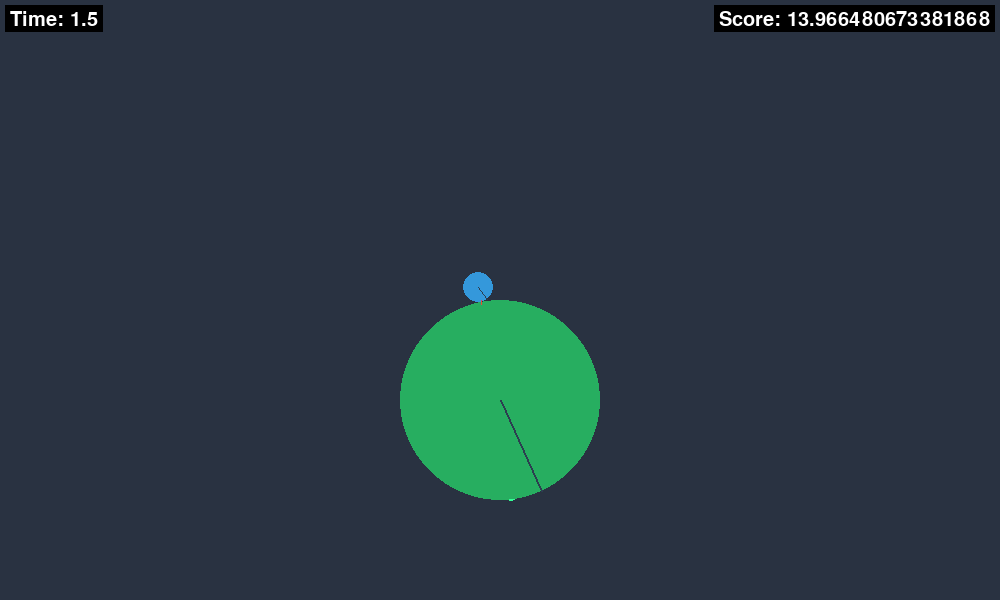

Loading the json memory file
self.x_axis_max_reward_rate:  0.021052631578947368


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
Starting training...
1
self.frame_count:  0
Logging to ./logs/PPO_1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Score:  14.852153328237193
1
1
1
1
1
1
1
1
1
self.frame_count:  60
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Score:  25.67646422914212
1
1
1
1
1
1
1
1
1
1
1
self.frame_count:  120
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
self.frame_count:  180
1
1
1
1
1
1
1
1
1
1
1
1
1
Score:  115.78246680009414
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
self.frame_count:  240
1
1
1
1
1
1
1
1
1
1
1
1
Score:  25.31442721849559
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
self.frame_count:  300
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Score:  22.0879469032769
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
self.frame_count:  360
1
Score:  15.947931063513657
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Score:  18.57320194402437
1
1
1
1
self.frame_count:  420
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Score:  20.73386858282

KeyboardInterrupt: 

In [11]:
train_ppo(
  total_timesteps=15000,
  n_steps=1024,
  batch_size=32,
  difficulty="medium",
  n_envs=1,
  load_model=None,
  eval_episodes=2,
)


In [ ]:
!cp /content/drive/MyDrive/balancing_ball/ppo_balancing_ball_final.zip /content/abc.zip

In [ ]:
train_ppo(
  total_timesteps=10000,
  n_steps=1024,
  batch_size=32,
  difficulty="medium",
  n_envs=1,
  load_model="/content/models/ppo_balancing_ball_final.zip",
  eval_episodes=2,
)
train_ppo(
  total_timesteps=10000,
  n_steps=1024,
  batch_size=32,
  difficulty="medium",
  n_envs=1,
  load_model="/content/models/ppo_balancing_ball_final.zip",
  eval_episodes=2,
)
train_ppo(
  total_timesteps=10000,
  n_steps=1024,
  batch_size=32,
  difficulty="medium",
  n_envs=1,
  load_model="/content/models/ppo_balancing_ball_final.zip",
  eval_episodes=2,
)